# EEG Preprocessing & Data Augmentation

This module handles preprocessing and data augmentation for EEG data.  
Preprocessing removes noise and artifacts to provide cleaner signals for model training.  
Data augmentation increases the size and diversity of the dataset to improve model robustness in detecting Alzheimer’s disease.


### Installing Dependencies


In [ ]:
%%capture
!git init
!git pull https://github.com/Leofierus/eeg-alzheimers-detection.git

In [ ]:
%%capture
!pip install mne

In [ ]:
!pip install pyprep
!pip install optuna
!pip install eeglabio
!conda install -c conda-forge eeglabio

In [ ]:
import mne
import os
import re
import warnings
import json

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict



# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Sanity Check  
Print basic data metrics and visualizations to verify proper import.

In [ ]:
data_dir = 'model-data'
test_dir = os.path.join(data_dir, 'test')
participants_file = os.path.join(data_dir, 'participants.tsv')



full_path = os.path.join(test_dir, "sub-001_eeg_chunk_0.set")
if not os.path.exists(full_path):
        print(f"⚠️ File sub-001_eeg_chunk_0.set not found in '{test_dir}'! Skipping...")


raw = mne.io.read_raw_eeglab(full_path, preload=False)

raw_2 = raw.copy()

data = raw_2.get_data()  # Shape: (n_channels, n_samples)
sfreq = raw_2.info['sfreq']  # Sampling frequency
ch_names = raw_2.info['ch_names']  # Channel names
print(ch_names)
print(data.shape[1])
print(sfreq)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
1425
95.0


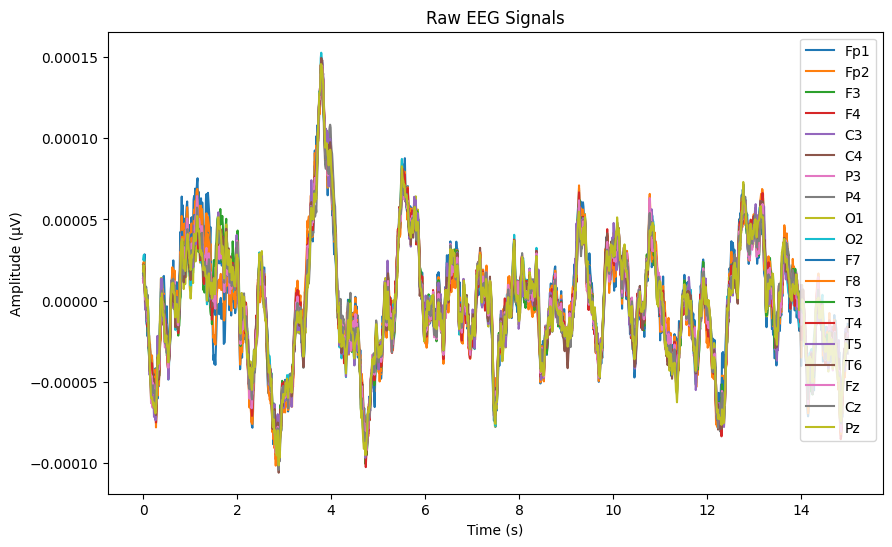

In [ ]:
time = np.arange(data.shape[1]) / sfreq  # Time axis in seconds
plt.figure(figsize=(10, 6))
for i, ch in enumerate(ch_names):
    plt.plot(time, data[i] , label=ch)  # Offset channels for better visibility
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Raw EEG Signals")
plt.legend(loc="upper right")
plt.show()


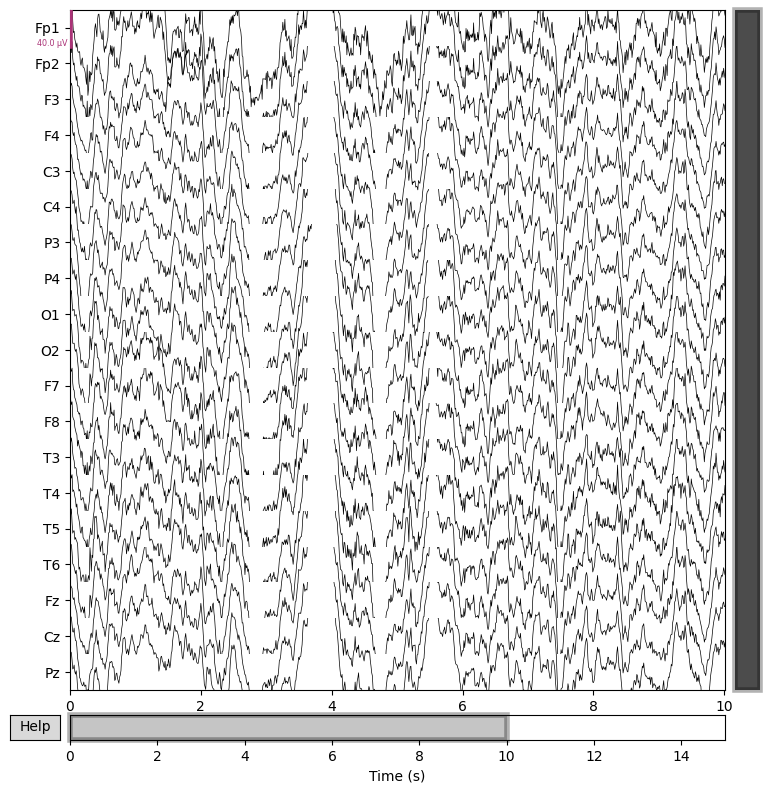

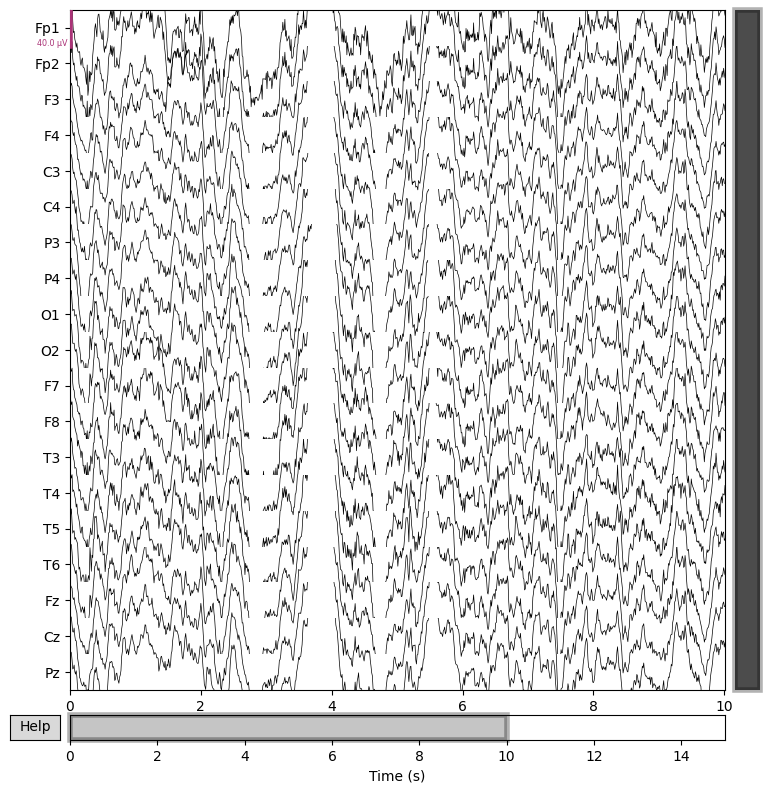

In [ ]:
raw.plot()

Effective window size : 15.000 (s)


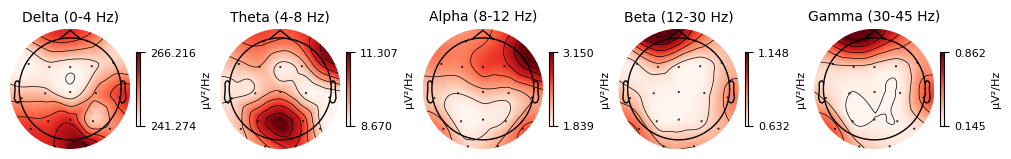

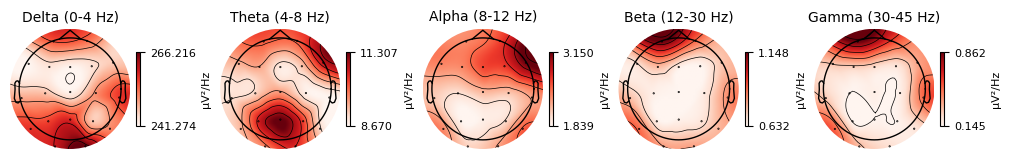

In [43]:
spectrum = raw.compute_psd()
spectrum.plot_topomap()

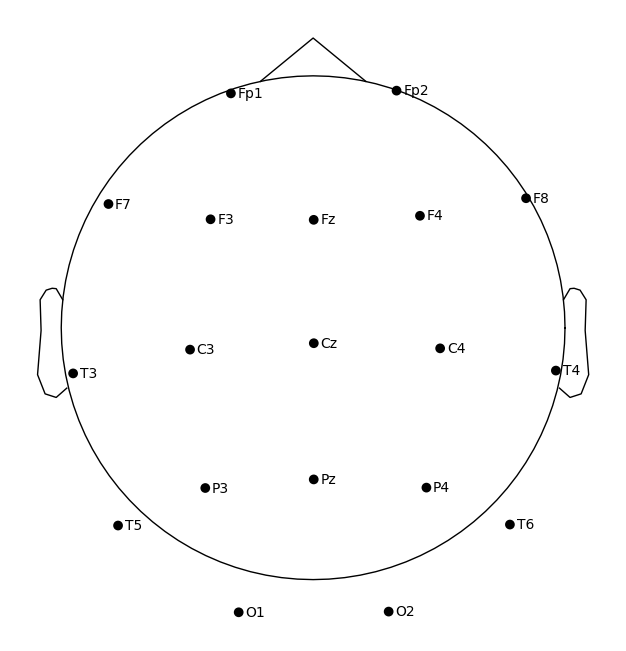

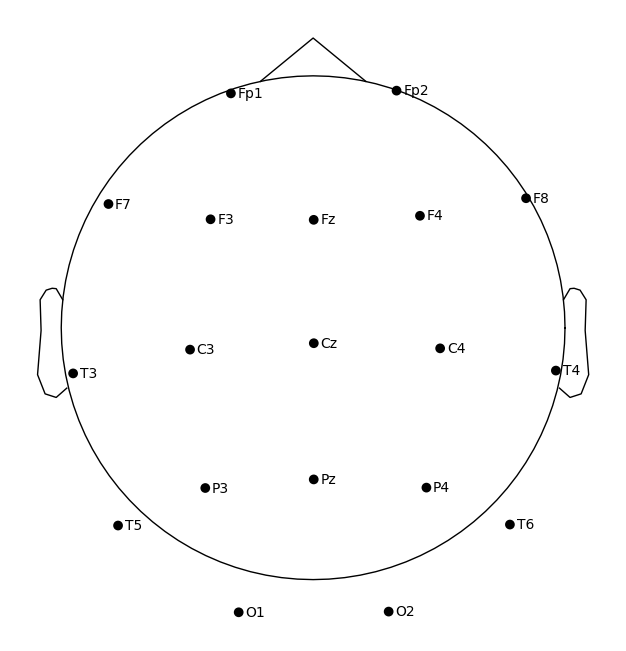

In [ ]:
raw_2.info.plot_sensors(show_names=True)

In [ ]:
events, _ = mne.events_from_annotations(raw)
raw.load_data()

<RawEEGLAB | sub-002_eeg_chunk_0.set, 19 x 1425 (15.0 s), ~238 KiB, data loaded>

# Preprocessing

## Concatenation

In [ ]:


def load_and_organize_chunks(base_dir):
    # Use defaultdict to gather chunk paths per subject
    subject_chunks = defaultdict(list)
    missing_chunks_report = {}

    # Scan both 'train' and 'test' directories
    for subfolder in ['train', 'test']:
        folder_path = os.path.join(base_dir, subfolder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.set'):
                match = re.match(r"(sub-\d+)_eeg_chunk_(\d+)\.set", filename)
                if match:
                    subject_id = match.group(1)
                    chunk_number = int(match.group(2))
                    full_path = os.path.join(folder_path, filename)
                    subject_chunks[subject_id].append((chunk_number, full_path))

    raw_data_by_subject = {}

    for subject_id, chunks in subject_chunks.items():
        # Sort chunks by their number
        sorted_chunks = sorted(chunks, key=lambda x: x[0])

        # Check for missing chunks
        chunk_numbers = [c[0] for c in sorted_chunks]
        expected = list(range(chunk_numbers[0], chunk_numbers[-1] + 1))
        missing = sorted(set(expected) - set(chunk_numbers))
        if missing:
            missing_chunks_report[subject_id] = missing
            print(f"[!] Missing chunks for {subject_id}: {missing}")

        # Load and concatenate the chunks
        raws = []
        for chunk_num, filepath in sorted_chunks:
            # print(f"Loading {filepath}")
            raw = mne.io.read_raw_eeglab(filepath, preload=True)
            raws.append(raw)

        combined_raw = mne.concatenate_raws(raws)
        raw_data_by_subject[subject_id] = combined_raw

    return raw_data_by_subject, missing_chunks_report


In [12]:
data_dir = 'model-data'
raws_by_subject, missing = load_and_organize_chunks(data_dir)

print("\nLoaded subjects:")
print(list(raws_by_subject.keys()))

if missing:
    print("\nMissing chunk report:")
    for subj, chunks in missing.items():
        print(f"{subj}: Missing chunks {chunks}")



Loaded subjects:
['sub-036', 'sub-018', 'sub-055', 'sub-008', 'sub-045', 'sub-026', 'sub-029', 'sub-017', 'sub-074', 'sub-058', 'sub-007', 'sub-039', 'sub-044', 'sub-054', 'sub-065', 'sub-041', 'sub-019', 'sub-034', 'sub-086', 'sub-048', 'sub-069', 'sub-047', 'sub-057', 'sub-079', 'sub-080', 'sub-071', 'sub-081', 'sub-005', 'sub-066', 'sub-025', 'sub-004', 'sub-059', 'sub-035', 'sub-020', 'sub-068', 'sub-014', 'sub-027', 'sub-084', 'sub-051', 'sub-032', 'sub-013', 'sub-087', 'sub-050', 'sub-040', 'sub-006', 'sub-088', 'sub-043', 'sub-031', 'sub-011', 'sub-062', 'sub-028', 'sub-010', 'sub-067', 'sub-042', 'sub-012', 'sub-023', 'sub-078', 'sub-016', 'sub-009', 'sub-073', 'sub-037', 'sub-033', 'sub-056', 'sub-049', 'sub-046', 'sub-001', 'sub-063', 'sub-077', 'sub-070', 'sub-085', 'sub-082', 'sub-064', 'sub-083', 'sub-075', 'sub-024', 'sub-076', 'sub-015', 'sub-052', 'sub-003', 'sub-022', 'sub-002', 'sub-061', 'sub-053', 'sub-072', 'sub-021', 'sub-060', 'sub-038', 'sub-030']


### Saving the Data

In [ ]:
# #saving raw data
output_path= "combined-raw"
output_dir = os.path.join(data_dir,output_path)
os.makedirs(output_dir, exist_ok=True)
for subject_id in raws_by_subject.keys():
  save_path = os.path.join(output_dir, f"{subject_id}_combined_raw.fif")
  raws_by_subject.get(subject_id).save(save_path, overwrite=True)


### Getting the Data 

In [ ]:
output_path = "combined-raw"
output_dir = os.path.join(data_dir, output_path)

raws_by_subject = {}

for filename in os.listdir(output_dir):
    if filename.endswith('_combined_raw.fif'):
        subject_id = filename.split('_')[0]
        
        # Load the raw data using mne
        raw = mne.io.read_raw_fif(os.path.join(output_dir, filename), preload=True)
        
        raws_by_subject[subject_id] = raw

# Now raws_by_subject contains all the raw data for each subject
print("Data loaded for subjects:", list(raws_by_subject.keys()))

# Filtering

In [ ]:
import mne

# Parameters
n_components = 15

# Stores cleaned data (raw + ICA object)
ica_by_subject = {}

for subject_id, raw in raws_by_subject.items():
    print(f"Processing {subject_id}...")

    raw_filtered = raw.copy().filter(l_freq=None, h_freq=1.0)

    # Run ICA
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter='auto')
    ica.fit(raw_filtered)

    ica_by_subject[subject_id] = {
        "filtered_raw": raw_filtered,
        "ica": ica
    }

print("Filtering and ICA complete. You can now manually mark `ica.exclude` before applying ICA.")


In [ ]:
# Apply Independent Component Analysis (ICA) per subject to detect and remove eye-blink artifacts, 
# then store the cleaned EEG signals.
for subject_id, data in ica_by_subject.items():
    raw_clean = data["filtered_raw"]
    ica = data["ica"]
    blink_like_inds,_ = ica.find_bads_eog(raw_clean, ch_name='Fp1')

    # Apply ICA to remove excluded components
    ica.apply(raw_clean)
    ica.exclude = blink_like_inds

    # Update with cleaned data
    data["cleaned_raw"] = raw_clean


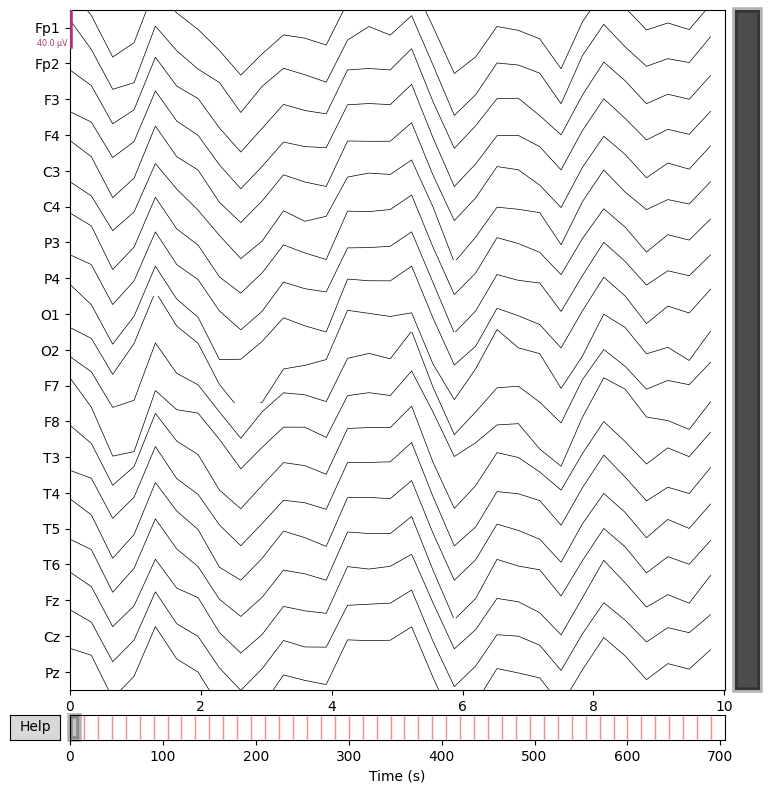

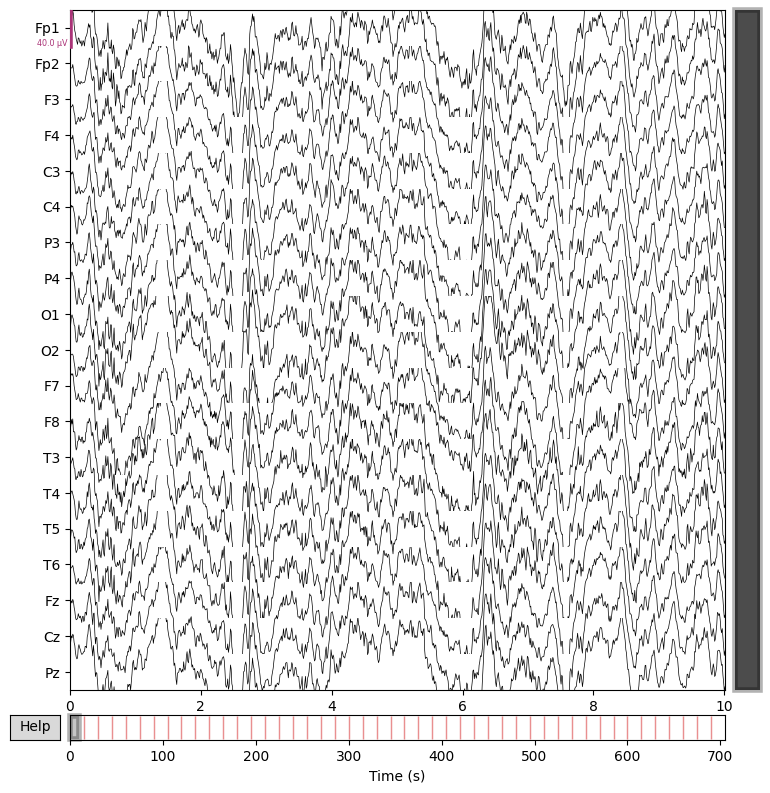

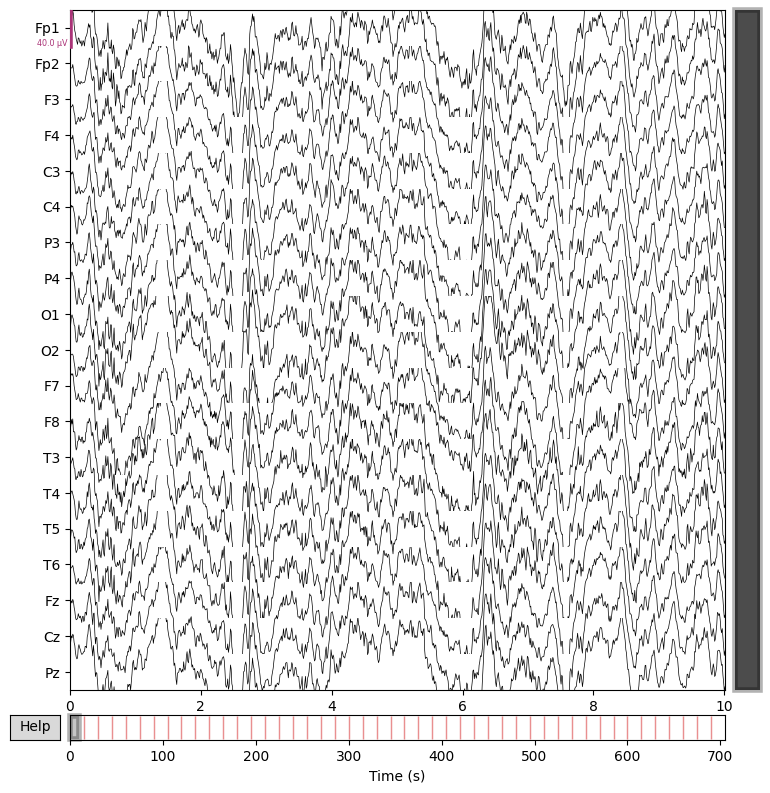

In [16]:
##Accessing cleaned raw
cleaned_raw = ica_by_subject["sub-060"]["cleaned_raw"]
cleaned_raw.plot()
raws_by_subject["sub-060"].plot()

In [ ]:
##interpolation
# Detect bad EEG channels based on abnormal signal variance, mark them, and replace their signals
# using interpolation to improve data quality.
def detect_bad_channels(raw, low_thresh=1e-7, high_thresh=1e-4):
    data = raw.get_data()
    stds = np.std(data, axis=1)

    bads = []
    for ch_name, std in zip(raw.ch_names, stds):
        if std < low_thresh or std > high_thresh:
            bads.append(ch_name)
    return bads

for subject_id, data in ica_by_subject.items():
    raw = data["cleaned_raw"]

    bads = detect_bad_channels(raw)
    raw.info['bads'] = bads


    #Interpolate
    raw.interpolate_bads(reset_bads=True)

In [ ]:
#refrencing (normalization)
for subject_id, data in ica_by_subject.items():
    raw = data["cleaned_raw"]
    raw.set_eeg_reference('average')

## Epoching

In [ ]:
for subject_id, data in ica_by_subject.items():
    print(subject_id, data["cleaned_raw"])

## Saving The Data

In [ ]:
# --- Dataset splitting and chunked export ------------------------------------
# Split by subject to avoid leakage, then cut each subject's continuous EEG into
# fixed-length windows and export to EEGLAB .set files.


# Define paths for saving the data
base_output_dir = "model-data/fixed_data_aug"
train_dir = os.path.join(base_output_dir, "train")
validate_dir = os.path.join(base_output_dir, "validate")
test_dir = os.path.join(base_output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validate_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define chunk parameters
sampling_freq = 95  # Sampling frequency in Hz
chunk_duration = 15  # Duration of each chunk in seconds
chunk_samples = chunk_duration * sampling_freq  # Number of samples in each chunk (15 * 95 = 1425 samples)

# Function to split raw continuous data into 15-second chunks
def split_into_chunks(raw_data, chunk_samples):
    data = raw_data.get_data()  # This gives you the continuous data (n_channels x n_samples)

    n_channels = data.shape[0]
    n_samples = data.shape[1]

    n_chunks = n_samples // chunk_samples
    
    chunks = []
    for i in range(n_chunks):
        start = i * chunk_samples
        end = (i + 1) * chunk_samples
        chunk = data[:, start:end] 
        chunks.append(chunk)
    
    chunks = np.array(chunks)
    return chunks

subject_ids = list(ica_by_subject.keys())

train_subjects, temp_subjects = train_test_split(subject_ids, test_size=0.4, random_state=42) 
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)  

for subject_id in val_subjects:
    data = ica_by_subject[subject_id]["cleaned_raw"]
    raw_chunks = split_into_chunks(data, chunk_samples)

    subject_validate_dir = os.path.join(validate_dir, subject_id)
    os.makedirs(subject_validate_dir, exist_ok=True)
    
    for i, chunk in enumerate(raw_chunks):
        chunk_file_name = f"{subject_id}_eeg_chunk_{i}.set"
        chunk_raw = mne.io.RawArray(chunk, info=data.info)  
        mne.export.export_raw(os.path.join(validate_dir, chunk_file_name), chunk_raw, fmt='eeglab', overwrite=True)

print("Validation data processing and saving complete.")

for subject_id in test_subjects:
    data = ica_by_subject[subject_id]["cleaned_raw"]
    raw_chunks = split_into_chunks(data, chunk_samples)

    subject_test_dir = os.path.join(test_dir, subject_id)
    os.makedirs(subject_test_dir, exist_ok=True)
    
    for i, chunk in enumerate(raw_chunks):
        chunk_file_name = f"{subject_id}_eeg_chunk_{i}.set"
        chunk_raw = mne.io.RawArray(chunk, info=data.info)  # Create a RawArray for each chunk
        mne.export.export_raw(os.path.join(test_dir, chunk_file_name), chunk_raw, fmt='eeglab', overwrite=True)

print("Test data processing and saving complete.")


## Data Augmentation

In [ ]:
# Define paths for saving the training data
train_dir = "model-data/fixed_data_aug/train"

# Ensure the directory exists
os.makedirs(train_dir, exist_ok=True)

# Data augmentation functions (same as before)
def add_noise(X, std=0.01):
    return X + np.random.normal(0, std, X.shape)

def time_shift(X, max_shift=10):
    return np.array([np.roll(epoch, np.random.randint(-max_shift, max_shift), axis=1) for epoch in X])

def amplitude_scale(X, scale_range=(0.9, 1.1)):
    return np.array([epoch * np.random.uniform(*scale_range) for epoch in X])

# Data Augmentation techniques in a dictionary
augmentation_techniques = {
    "noise": add_noise,
    "time_shift": time_shift,
    "amplitude_scale": amplitude_scale
}

# Loop through each subject in the training set (this assumes `train_subjects` contains the subject IDs for training)
for subject_id in train_subjects:
    data = ica_by_subject[subject_id]["cleaned_raw"]
    
    # Split the raw data into 15-second chunks using the already defined function
    raw_chunks = split_into_chunks(data, chunk_samples)
    
    # Create directory for the training subject
    # subject_train_dir = os.path.join(train_dir, subject_id)
    # os.makedirs(subject_train_dir, exist_ok=True)
        # Save the original raw chunks (without augmentation)
    for i, chunk in enumerate(raw_chunks):
        chunk_file_name = f"{subject_id}_eeg_chunk_{i}.set"
        chunk_raw = mne.io.RawArray(chunk, info=data.info)
        mne.export.export_raw(os.path.join(train_dir, chunk_file_name), chunk_raw, fmt='eeglab', overwrite=True)
    
    # Apply data augmentation and save chunks for training data
    for aug_name, aug_func in augmentation_techniques.items():
        augmented_data = aug_func(raw_chunks)  # Apply the augmentation technique
        
        # Save the augmented data in 15-second chunks
        for i, chunk in enumerate(augmented_data):
            chunk_file_name = f"{subject_id}_eeg_chunk_{i}_{aug_name}.set"
            chunk_raw = mne.io.RawArray(chunk, info=data.info)
            mne.export.export_raw(os.path.join(train_dir, chunk_file_name), chunk_raw, fmt='eeglab', overwrite=True)

print("Training data processing and saving complete.")


In [30]:
from collections import Counter

def count_labels_in_split(folder_path):
    label_counts = Counter()
    total_files = 0

    for filename in os.listdir(folder_path):
        if not filename.endswith(".npy"):
            continue

        subject_id = filename.split("_X")[0]
        label = subject_labels.get(subject_id)

        if label:
            label_counts[label] += 1
            total_files += 1

    return label_counts, total_files

# Get label counts
train_counts, train_total = count_labels_in_split("model-data/epochs-numpy/train")
test_counts, test_total = count_labels_in_split("model-data/epochs-numpy/test")

# Convert to percentages
train_percent = {label: f"{(count/train_total)*100:.2f}%" for label, count in train_counts.items()}
test_percent = {label: f"{(count/test_total)*100:.2f}%" for label, count in test_counts.items()}

# Show report
print("Train Label Distribution (%):", train_percent)
print("Test Label Distribution (%):", test_percent)

Train Label Distribution (%): {'C': '34.58%', 'F': '25.83%', 'A': '39.58%'}
Test Label Distribution (%): {'A': '43.27%', 'F': '25.00%', 'C': '31.73%'}


In [ ]:
#Delete files not in test and train 
for f in os.listdir(source_dir):
    if f.endswith(".npy") and not f.startswith(("train", "test")):
        os.remove(os.path.join(source_dir, f)) 
